In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import os

zmomentum = 2

directory = os.getcwd()+f"Kaon_data/Kaon_{zmomentum}"

folder = Path(directory).glob("*")

# allconfig = {}
# counter = 0
# for k in folder:
#     file = Path(k).glob("*")
#     for i in file:
#         counter += 1
#         f = open(i)
#         for line in f:
#             p = (int(line.split(" ")[0])**2)+(int(line.split(" ")[1])**2)
#             if p not in allconfig:
#                 allconfig[p] = []
#                 allconfig[p].append(float(line.split(" ")[4]))
#             else:
#                 allconfig[p].append(float(line.split(" ")[4]))

allconfig = {}
for k in folder:
    file = Path(k).glob("*")
    for i in file:
        f = open(i)
        for line in f:
            p = (int(line.split(" ")[0])**2)+(int(line.split(" ")[1])**2)
            if p not in allconfig:
                allconfig[p] = []
                allconfig[p].append(float(line.split(" ")[4]))
            else:
                allconfig[p].append(float(line.split(" ")[4]))


In [113]:
for i in allconfig:
    allconfig[i] = np.reshape(allconfig[i],(-1,64))

print(np.shape(allconfig[0]))
print(type(allconfig[0]))

(2396, 64)
<class 'numpy.ndarray'>


In [114]:
# Momentum Averaging
mommy = {}
for i in allconfig:
    mommy[i] = []
    if i == 0:
        for j in range(0, len(allconfig[i]), 2):
            mommy[i].append((allconfig[i][j]+allconfig[i][j+1])/2)
    elif i == 1 or i == 2 or i == 4 or i == 8 or i == 9 or i == 16:
        for j in range(0, len(allconfig[i]), 8):
            mommy[i].append((allconfig[i][j]+allconfig[i][j+1]+allconfig[i][j+2]+allconfig[i][j+3]+allconfig[i][j+4]+allconfig[i][j+5]+allconfig[i][j+6]+allconfig[i][j+7])/8)
    elif i == 5 or i == 10:
        for j in range(0, len(allconfig[i]), 16):
            mommy[i].append((allconfig[i][j]+allconfig[i][j+1]+allconfig[i][j+2]+allconfig[i][j+3]+allconfig[i][j+4]+allconfig[i][j+5]+allconfig[i][j+6]+allconfig[i][j+7]+allconfig[i][j+8]+allconfig[i][j+9]+allconfig[i][j+10]+allconfig[i][j+11]+allconfig[i][j+12]+allconfig[i][j+13]+allconfig[i][j+14]+allconfig[i][j+15])/16)

# print(np.shape(mommy[16]))

In [115]:
def timeavg(arr):
    arr= np.array(arr)
    rev = np.flipud(arr)

    cont = arr+rev
    cont = cont/2
    cont[0] = arr[0]
    cont[32] = arr[32]
    return cont[:33]

def energy(arr):
    ene = []
    for i in range(len(arr)-1):
        var = arr[i]/arr[i+1]
        if var > 0:
            ene.append(np.log(var))
        else:
            ene.append(0)
    return ene

def jackknife(arr):
    n = len(arr)
    arr = np.array(arr)
    s = np.sum(arr)

    bin = []
    for i in range(n):
        bin.append(s-arr[i])
    
    bin = np.array(bin)/(n-1)
    
    return bin

In [116]:
timeavged = {}
for i in allconfig:
    timeavged[i] = []
    for j in allconfig[i]:
        timeavged[i].append(timeavg(j))
    timeavged[i] = np.array(timeavged[i])

print(np.shape(timeavged[0]))

(2396, 33)


In [117]:
momns = [i for i in timeavged]
counts = [int((np.shape(timeavged[i])[0])/1198) for i in timeavged]

print(momns)
print(counts)

[0, 1, 2, 4, 5, 8, 9, 10, 16]
[2, 8, 8, 8, 16, 8, 8, 16, 8]


In [118]:
enbin = {}
for i in timeavged:
    enbin[i] = []
    for j in timeavged[i]:
        enbin[i].append(energy(j))
    # print(enbin[i])

finbin = {}
for i in enbin:
    finbin[i] = np.transpose(enbin[i])

print(np.shape(finbin[0]))

jackbin = {}
for i in finbin:
    jackbin[i] = []
    for j in finbin[i]:
        jackbin[i].append(jackknife(j))

(32, 2396)


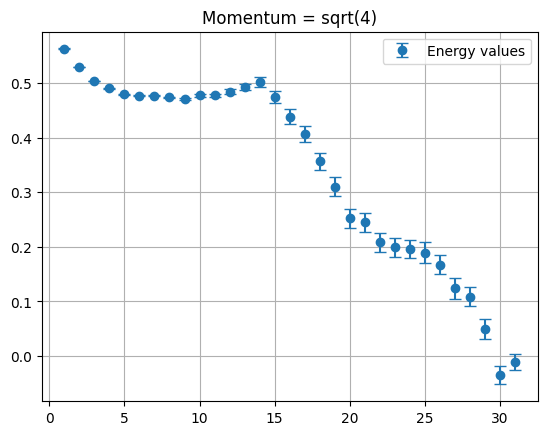

In [119]:
# from sympy import *

binno =0
# for binno in momns:
y = []
factor = len(jackbin[binno][0])
y_err = []

for i in jackbin[binno]:
    avg = sum(i)/factor
    y.append(avg)
    stdevar = 0
    for j in i:
        stdevar += (j-avg)**2
    stdevar = np.sqrt(stdevar*((factor-1)/factor))
    y_err.append(stdevar)

# print(np.shape(y))

x = np.linspace(1,31,31)
# plt.xlim(0,10.5)
# plt.ylim(0.7,1)
total_momentum = zmomentum**2 + binno
tm = "sqrt({})".format(total_momentum)
plt.errorbar(x,y[1:],y_err[1:],fmt='o',capsize=4)
plt.legend(['Energy values'])
plt.title(label="Momentum = {}".format(tm))
plt.savefig('/Users/rijul/Desktop/All/MIT/Summer/QCD/plotsave/plot_4_{}.png'.format(tm))
plt.grid()
plt.show()

In [120]:
# start and end inclusive
def plat_fit(start, end, y, y_err):
    meanvals = np.array(y[start:end+1])
    errvals = np.array(y_err[start:end+1])
    errvals = 1/(errvals**2)
    normalize = np.sum(errvals)
    plat_energy = np.sum((meanvals*errvals)/normalize)

    meanvals = jackknife(meanvals)

    stdevar = 0
    for i in meanvals:
        stdevar += (i-plat_energy)**2
    stdevar = np.sqrt(stdevar*((end-start)/(end-start+1)))

    return (plat_energy,stdevar)
    

0.47578796078047064+-0.001069966159122243


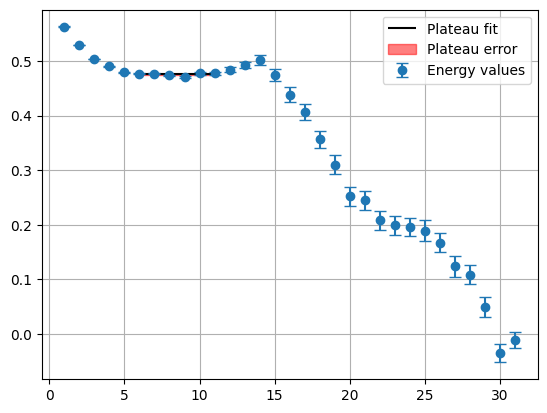

In [124]:
start = 6
end = 11
platval = plat_fit(start, end, y, y_err)
subx = np.linspace(start,end,end-start+1)
suby = np.full(end-start+1,platval[0])
subyerr = np.full(end-start+1,platval[1])

print(str(platval[0])+'+-'+str(platval[1]))

# plt.xlim(0,10.5)
# plt.ylim(0.7,1)
plt.hlines(platval[0],start,end,colors='black')
plt.fill_between(subx,suby+subyerr,suby-subyerr,color='red',alpha=0.5)
plt.errorbar(x,y[1:],y_err[1:],fmt='o',capsize=4)
plt.legend(['Plateau fit','Plateau error','Energy values'])
plt.grid()
# plt.savefig('/Users/rijul/Desktop/All/MIT/Summer/Plat_fit_plot004.pdf')
plt.show()